In [8]:
import yfinance as yf
import matplotlib.pyplot as plt

In [9]:
sp500 = yf.Ticker("^GSPC")

In [10]:
sp500 = sp500.history(period="max")

In [11]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-07-01 00:00:00-04:00,6187.250000,6210.779785,6177.970215,6198.009766,6275310000,0.0,0.0
2025-07-02 00:00:00-04:00,6193.879883,6227.600098,6188.290039,6227.419922,5645710000,0.0,0.0
2025-07-03 00:00:00-04:00,6246.459961,6284.649902,6246.459961,6279.350098,3378110000,0.0,0.0


In [12]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2025-06-24 00:00:00-04:00', '2025-06-25 00:00:00-04:00',
               '2025-06-26 00:00:00-04:00', '2025-06-27 00:00:00-04:00',
               '2025-06-30 00:00:00-04:00', '2025-07-01 00:00:00-04:00',
               '2025-07-02 00:00:00-04:00', '2025-07-03 00:00:00-04:00',
               '2025-07-07 00:00:00-04:00', '2025-07-08 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24494, freq=None)

<Axes: xlabel='Date'>

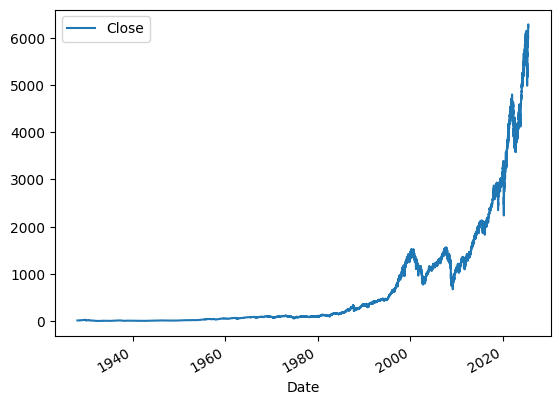

In [13]:
sp500.plot.line(y="Close", use_index=True)

In [ ]:
# Cleaning data
del sp500["Dividends"]
del sp500["Stock Splits"]